## ONNX Runtime on Azure Kubernetes Service

Deploying Facial Emotion Recognition (FER+) using Docker Images

This example shows how to deploy an image classification neural network using ONNX Runtime on GPU compute SKUs in Azure. This example makes use of the Facial Expression Recognition (FER) dataset and Open Neural Network eXchange format (ONNX) on the Azure Machine Learning platforme


#### 1. Prerequisites to install A
Please restart kernel after pip installs to sync environment with new modules.

In [1]:
#! pip install matplotlib onnx opencv-python
# pip install azure-ai-ml azure-identity datasets azure-cli mlflow

#### 2. Connect to Azure Machine Learning workspace

Before we dive in the code, you'll need to connect to your workspace. The workspace is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

For this lab, we've already setup an AzureML Workspace for you. If you'd like to learn more about `Workspace`s, please reference [`AzureML's documentation`](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace?view=azureml-api-2&tabs=azure-portal).

We are using the `DefaultAzureCredential` to get access to workspace. `DefaultAzureCredential` should be capable of handling most scenarios. If you want to learn more about other available credentials, go to [`Set up authentication`](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk&view=azureml-api-2) for more available credentials.

In [1]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml import Input
from azure.ai.ml.dsl import pipeline
from dotenv import dotenv_values
from dotenv import load_dotenv
from utils.login import get_ws_client
from utils.datasets import get_labels_dataset, create_datasets
from utils.computer import create_gpu_cluster
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

### .env file to use your service principal account

```md
RESOURCE_GROUP=
SUBSCRIPTION_ID=
AZUREML_WORKSPACE_NAME=
TENANTID=
AZURE_CLIENT_ID=
AZURE_TENANT_ID=
AZURE_CLIENT_SECRET=
```

In [2]:
# Load env and login to Workspace
load_dotenv(".env")
config = dotenv_values(".env")


# Enter details of your Azure Machine Learning workspace
subscription_id = config.get("SUBSCRIPTION_ID")
resource_group = config.get("RESOURCE_GROUP")
workspace = config.get("AZUREML_WORKSPACE_NAME")

In [3]:
credential = DefaultAzureCredential()
# Check if given credential can get token successfully.
credential.get_token("https://management.azure.com/.default")


ml_client = get_ws_client(
    credential, subscription_id, resource_group, workspace
)
print(ml_client)

MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x000001C14A3D7F90>,
         subscription_id=***REMOVED***,
         resource_group_name=olonok-ml,
         workspace_name=olonok-ml)


#### 1. Obtain a model from the ONNX Model Zoo

https://www.cntk.ai/OnnxModels/emotion_ferplus/opset_7/emotion_ferplus.tar.gz



In [7]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
# urllib is a built-in Python library to download files from URLs

# Objective: retrieve the latest version of the ONNX Emotion FER+ model files from the
# ONNX Model Zoo and save it in the same folder as this tutorial

import urllib.request

onnx_model_url = "https://www.cntk.ai/OnnxModels/emotion_ferplus/opset_7/emotion_ferplus.tar.gz"

urllib.request.urlretrieve(onnx_model_url, filename="emotion_ferplus.tar.gz")

# the ! magic command tells our jupyter notebook kernel to run the following line of 
# code from the command line instead of the notebook kernel

# We use tar and xvcf to unzip the files we just retrieved from the ONNX model zoo

!tar xvzf emotion_ferplus.tar.gz


x emotion_ferplus/
x emotion_ferplus/model.onnx
x emotion_ferplus/test_data_set_0/
x emotion_ferplus/test_data_set_0/input_0.pb
x emotion_ferplus/test_data_set_0/output_0.pb
x emotion_ferplus/test_data_set_1/
x emotion_ferplus/test_data_set_1/input_0.pb
x emotion_ferplus/test_data_set_1/output_0.pb
x emotion_ferplus/test_data_set_2/
x emotion_ferplus/test_data_set_2/input_0.pb
x emotion_ferplus/test_data_set_2/output_0.pb


#### Load Azure ML workspace



In [6]:
# Check core SDK version number
import azureml.core
from azureml.core import Workspace
print("SDK version:", azureml.core.VERSION)


SDK version: 1.57.0


In [11]:
from azureml.core import Workspace

# read existing workspace from config.json
ws = Workspace(subscription_id=subscription_id, resource_group=resource_group, workspace_name=workspace)

print(ws.name, ws.location, ws.resource_group, sep = '\n')

olonok-ml
uksouth
olonok-ml


#### Register your ONNX model with Azure ML



In [13]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes


In [15]:
model_dir = "emotion_ferplus" # replace this with the location of your model files


file_model = Model(
    path= model_dir + "/" + "model.onnx",
    type=AssetTypes.CUSTOM_MODEL,
    name="onnx_emotion",
    description= "FER+ emotion recognition CNN from ONNX Model Zoo",
)
ml_client.models.create_or_update(file_model)



Uploading model.onnx (< 1 MB): 100%|###########################################################################################################| 35.0M/35.0M [01:01<00:00, 568kB/s]




Model({'job_name': None, 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'onnx_emotion', 'description': 'FER+ emotion recognition CNN from ONNX Model Zoo', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/***REMOVED***/resourceGroups/olonok-ml/providers/Microsoft.MachineLearningServices/workspaces/olonok-ml/models/onnx_emotion/versions/1', 'Resource__source_path': None, 'base_path': 'D:\\repos\\onnx\\azureml', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x000001C176376450>, 'serialize': <msrest.serialization.Serializer object at 0x000001C1752A17D0>, 'version': '1', 'latest_version': None, 'path': 'azureml://subscriptions/***REMOVED***/resourceGroups/olonok-ml/workspaces/olonok-ml/datastores/workspaceblobstore/paths/LocalUpload/7234b0d83a59c8bd791994828d9fabee/model.onnx', 'datastore': None, 'utc_time_created': None, 'flavors': None, 'arm_type': 'model_ve

In [16]:
models = ws.models
for name, m in models.items():
    print("Name:", name,"\tVersion:", m.version, "\tDescription:", m.description, m.tags)

Name: onnx_emotion 	Version: 1 	Description: FER+ emotion recognition CNN from ONNX Model Zoo {}


#### Create Scoring file

In [31]:
%%writefile code/score.py
import json
import numpy as np
import onnxruntime
import sys
import os
from azureml.core.model import Model
import time

def init():
    global session, input_name, output_name
    model = "model.onnx"
    
    # Load the model in onnx runtime to start the session    
    session = onnxruntime.InferenceSession(model, None)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name 
    
def run(input_data):
    '''Purpose: evaluate test input in Azure Cloud using onnxruntime.
        We will call the run function later from our Jupyter Notebook 
        so our azure service can evaluate our model input in the cloud. '''

    try:
        # load in our data, convert to readable format
        data = np.array(json.loads(input_data)['data']).astype('float32')
        
        # pass input data to do model inference with ONNX Runtime
        start = time.time()
        r = session.run([output_name], {input_name : data})
        end = time.time()
        
        result = emotion_map(postprocess(r[0]))
        
        result_dict = {"result": result,
                      "time_in_sec": [end - start]}
    except Exception as e:
        result_dict = {"error": str(e)}
    
    return json.dumps(result_dict)

def emotion_map(classes, N=1):
    """Take the most probable labels (output of postprocess) and returns the 
    top N emotional labels that fit the picture."""
    
    emotion_table = {'neutral':0, 'happiness':1, 'surprise':2, 'sadness':3, 
                     'anger':4, 'disgust':5, 'fear':6, 'contempt':7}
    
    emotion_keys = list(emotion_table.keys())
    emotions = []
    for i in range(N):
        emotions.append(emotion_keys[classes[i]])
    return emotions

def softmax(x):
    """Compute softmax values (probabilities from 0 to 1) for each possible label."""
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(scores):
    """This function takes the scores generated by the network and 
    returns the class IDs in decreasing order of probability."""
    prob = softmax(scores)
    prob = np.squeeze(prob)
    classes = np.argsort(prob)[::-1]
    return classes

Writing score.py


##### Create Endpoint

In [37]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)
# Define an endpoint name
#endpoint_name = "onnx_inference_emotion_ferplus"

# Example way to define a random name
import datetime

endpoint_name = "endpt-" + datetime.datetime.now().strftime("%m%d%H%M%f")

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name = endpoint_name, 
    description="this is a endpoint for onnx inference emotion_ferplus model",
    auth_mode="key"
)

ml_client.online_endpoints.begin_create_or_update(endpoint).wait()
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://endpt-08211634019917.uksouth.inference.ml.azure.com/score', 'openapi_uri': 'https://endpt-08211634019917.uksouth.inference.ml.azure.com/swagger.json', 'name': 'endpt-08211634019917', 'description': 'this is a endpoint for onnx inference emotion_ferplus model', 'tags': {}, 'properties': {'azureml.onlineendpointid': '/subscriptions/***REMOVED***/resourcegroups/olonok-ml/providers/microsoft.machinelearningservices/workspaces/olonok-ml/onlineendpoints/endpt-08211634019917', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/***REMOVED***/providers/Microsoft.MachineLearningServices/locations/uksouth/mfeOperationsStatus/oeidp:9a0f0906-2e91-4aab-8570-30319c6b7c6c:5392d671-aa5c-42ff-aa08-466557b8a1e2?api-version=2022-02-01-preview'}, 'print_as_yaml': True, 'id': '/subscriptions/***REMOVED***/resourceGroups/olonok-ml/providers/Microsoft.MachineLearningServices

In [38]:
image = "mcr.microsoft.com/azureml/curated/acpt-pytorch-2.2-cuda12.1:13"

In [39]:
for m in ml_client.models.list():
    print(m)

creation_context:
  created_at: '2024-08-21T14:24:35.700236+00:00'
  created_by: ***REMOVED***
  created_by_type: Application
  last_modified_at: '2024-08-21T14:24:35.700236+00:00'
  last_modified_by: ***REMOVED***
  last_modified_by_type: Application
id: azureml:/subscriptions/***REMOVED***/resourceGroups/olonok-ml/providers/Microsoft.MachineLearningServices/workspaces/olonok-ml/models/onnx_emotion
latest_version: '1'
name: onnx_emotion
properties: {}
tags: {}
type: custom_model



In [40]:
env = Environment(
    image=image,
)
model = ml_client.models.get(name="onnx_emotion", version = 1)

In [74]:
ml_client.models.download(name="onnx_emotion", version = 1)

##### 9.3 Deploy scoring file to the endpoint

In [75]:
model

Model({'job_name': None, 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'onnx_emotion', 'description': 'FER+ emotion recognition CNN from ONNX Model Zoo', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/***REMOVED***/resourceGroups/olonok-ml/providers/Microsoft.MachineLearningServices/workspaces/olonok-ml/models/onnx_emotion/versions/1', 'Resource__source_path': None, 'base_path': 'D:\\repos\\onnx\\azureml', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x000001C176AA7A10>, 'serialize': <msrest.serialization.Serializer object at 0x000001C1769DAAD0>, 'version': '1', 'latest_version': None, 'path': 'azureml://subscriptions/***REMOVED***/resourceGroups/olonok-ml/workspaces/olonok-ml/datastores/workspaceblobstore/paths/LocalUpload/7234b0d83a59c8bd791994828d9fabee/model.onnx', 'datastore': None, 'utc_time_created': None, 'flavors': None, 'arm_type': 'model_ve

In [42]:


blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=endpoint_name,
    model=model,
    environment=env,
    code_configuration=CodeConfiguration(
        code="./code", scoring_script="score.py"
    ),
    instance_type="Standard_NC4as_T4_v3",
    instance_count=1,
)

ml_client.online_deployments.begin_create_or_update(blue_deployment)

Check: endpoint endpt-08211634019917 exists


......................................................................................................................................

In [43]:
KEY = "lEIn8yDRDWAyOkVtQHUj6Mejf8pYyz7Z"
# Documentation: https://learn.microsoft.com/en-us/azure/machine-learning/how-to-deploy-online-endpoints
# Troubleshooting: https://learn.microsoft.com/en-us/azure/machine-learning/how-to-troubleshoot-online-endpoints
  
# Preprocessing functions take your image and format it so it can be passed
# as input into our ONNX model
import cv2

def rgb2gray(rgb):
    """Convert the input image into grayscale"""
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def resize_img(img):
    """Resize image to MNIST model input dimensions"""
    img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_AREA)
    img.resize((1, 1, 64, 64))
    return img

def preprocess(img):
    """Resize input images and convert them to grayscale."""
    if img.shape == (64, 64):
        img.resize((1, 1, 64, 64))
        return img
    
    grayscale = rgb2gray(img)
    processed_img = resize_img(grayscale)
    return processed_img


Old Dimensions:  (504, 337, 4)
New Dimensions:  (1, 1, 64, 64)


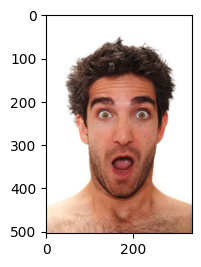

In [67]:
your_test_image = "image/scared.png"

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import json
import os

if your_test_image != "<path to file>":
    img = mpimg.imread(your_test_image)
    plt.subplot(1,3,1)
    plt.imshow(img, cmap = plt.cm.Greys)
    print("Old Dimensions: ", img.shape)
    img = preprocess(img)
    print("New Dimensions: ", img.shape)
else:
    img = None

In [68]:
input_data = json.dumps({'data': img.tolist()})

In [69]:
np.array(json.loads(input_data)['data']).astype('float32')

array([[[[1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         ...,
         [0.85196626, 0.83446074, 0.8318813 , ..., 0.5626403 ,
          0.5361905 , 0.5188913 ],
         [0.8121761 , 0.78579354, 0.79210204, ..., 0.52722955,
          0.52756983, 0.5019983 ],
         [0.79269755, 0.7750201 , 0.7425384 , ..., 0.49988765,
          0.50688636, 0.47975776]]]], dtype=float32)

In [70]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) 

In [76]:


body = str.encode(input_data)

url = 'https://endpt-08211634019917.uksouth.inference.ml.azure.com/score'
# Replace this with the primary/secondary key, AMLToken, or Microsoft Entra ID token for the endpoint
api_key = KEY
if not api_key:
    raise Exception("A key should be provided to invoke the endpoint")


headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key), 'azureml-model-deployment': 'blue' }

req = urllib.request.Request(url, body, headers)
try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

b'"{\\"result\\": [\\"neutral\\"], \\"time_in_sec\\": [0.008311271667480469]}"'


In [73]:
json.loads(result.decode())

'{"result": ["neutral"], "time_in_sec": [0.04197096824645996]}'

##### 9.5: Delete the online endpoint
Don't forget to delete the online endpoint, else you will leave the billing meter running for the compute used by the endpoint

In [77]:
ml_client.online_endpoints.begin_delete(name=endpoint_name).wait()

........................................................................